# Measuring features in a time-lapse dataset

In this notebook, we will develop a workflow on a single timepoint of a timelapse and will learn how to apply the workflow on the whole time-lapse. This involves the following steps: preoprocessing, segmentation and feature extraction. 

In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle
from skimage.measure import regionprops_table
import numpy as np
import pandas as pd

## Developing a workflow

First, we are reading in the image, scaling it and converting it to a [numpy](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/12_image_analysis_basics/05_Masking_images.html)-array:

In [2]:
# reading in the image
image_stack = imread("../../data/CalibZAPWfixed_000154_max.tif")[::10,:200,:200]

# scaling the image and converting it to a np-array
image_stack = np.asarray(cle.scale(image_stack, factor_z=1, factor_y=6, factor_x=6, auto_size=True))

In [3]:
image_stack.shape

(10, 1200, 1200)

Next, we define a function `segment_single_image` which does [background subtraction](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/18_image_filtering/03_background_removal.html) using `top_hat_box` and segmentation using [`voronoi_otsu_labeling`](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html). 

Therefore, it needs as input:
- an image
- `bg_radius` (= background radius)
- `spot_sigma` and `outline_sigma`. 

It returns the labels as numpy-array:

In [4]:
def segment_single_image(image, bg_radius=50, spot_sigma=10, outline_sigma=3):
    background_subtracted = cle.top_hat_box(image, radius_x=bg_radius, radius_y=bg_radius)
    labels = cle.voronoi_otsu_labeling(background_subtracted, spot_sigma=spot_sigma, outline_sigma=outline_sigma)
    return np.asarray(labels)

We try the function on timepoint 6 (= 5th frame as we are counting from 0):

In [5]:
tp_6 = segment_single_image(image_stack[5])
tp_6

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 177, 177, 177],
       [  0,   0,   0, ..., 177, 177, 177],
       [  0,   0,   0, ..., 177, 177, 177]], dtype=uint32)

## Visualizing images and image stacks

We can visualize our numpy-array like this:

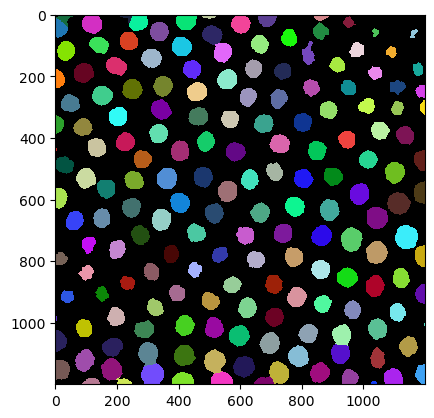

In [6]:
cle.imshow(tp_6, labels=True)

Now we can run our function in a for-loop over the whole time-lapse dataset:

In [7]:
segmented_slices = [segment_single_image(image) for image in image_stack]
segmented_stack = np.asarray(segmented_slices)

Our `segmented_stack` should keep the same shape as the original `image_stack`:

In [8]:
segmented_stack.shape

(10, 1200, 1200)

It does! Now, we can use `stackview` to visualize our whole image_stack. The function `curtain` provides a slider to visualize the label image on top of the original image.

In [9]:
import stackview
stackview.curtain(image_stack, segmented_stack, zoom_factor=0.3)

If you move the `Slice` slider you can see the segmentation result of the individual timepoints. As you can see, objects are not keeping the same label number over several frames. We are not doing tracking here, just segmenting timepoint-by-timepoint.

## Measuring features on an image and a label image

Our goal is to extract features from this time-lapse dataset.
Therefore, we define another function `analyze_mean_intensity_single_timepoint`. The name says it all.

In [10]:
def analyze_mean_intensity_single_timepoint(image, labels, frame):
    df = pd.DataFrame(regionprops_table(labels[frame], intensity_image=image[frame], properties=['mean_intensity']))
    df['frame'] = frame
    return df

Now, we try it out on timepoint 6 of our time-lapse dataset:

In [11]:
df = analyze_mean_intensity_single_timepoint(image_stack, segmented_stack, 5)

In [12]:
df

,mean_intensity,frame
0,193.721710,5
1,154.925858,5
2,142.510788,5
3,102.849998,5
4,88.570175,5
...,...,...
172,154.884216,5
173,147.652908,5
174,126.156464,5
175,89.161293,5


As we can see, the function returns a table with the mean intensities of the labels in a particular frame. 

## Measuring features on the whole time-lapse dataset

Next, we want to apply our function on the whole stack. We use a [for-loop](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/02_python_basics/08_loops.html) to do so:

In [13]:
num_frames = image_stack.shape[0]
all_frames_df = pd.concat([analyze_mean_intensity_single_timepoint(image_stack, segmented_stack, t) for t in range(num_frames)])
all_frames_df

,mean_intensity,frame
0,223.347107,0
1,93.042557,0
2,112.046814,0
3,192.766434,0
4,162.704330,0
...,...,...
335,135.748642,9
336,116.306427,9
337,121.075317,9
338,98.173592,9


Now, we want to measure how long it takes to execute our code snipped. Therefore, we use [`timeit`](https://docs.python.org/3/library/timeit.html).

In [14]:
import timeit

In [15]:
%%timeit
pd.concat([analyze_mean_intensity_single_timepoint(image_stack, segmented_stack, t) for t in range(num_frames)])

115 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It tells us the execution time per loop (here per image) in our time-lapse dataset.

## Short side note: What is a good way to write a function?

If we define functions, one function should do only one thing. Then, this function can be called by another function which brings another novelty. We call this modularization. Have a look at the two functions`get_intensity_for_timepoint` and `get_intensity`:

In [16]:
def get_intensity_for_timepoint(intensity_image, label_layer):
    stats = regionprops_table(label_layer, intensity_image=intensity_image, properties=['mean_intensity'])
    return stats['mean_intensity']

def get_intensity(intensity_image_stack, labels_layer_stack):
    result = []        
    for intensity_image, label_layer in zip(intensity_image_stack, labels_layer_stack):
        result.append(get_intensity_for_timepoint(intensity_image, label_layer))
    return result

The first function measures the mean_intensity and the second function applies this on a whole time-lapse dataset. Therefore, the functions both have one main task and the first function is nested in the second one.

## Libraries to extract features of all timepoints

Now, we want to measure different intensity-based parameters on all timepoints. Therefore, we use `regionprops_table_all_frames` from [napari_skimage_regionprops](https://github.com/haesleinhuepf/napari-skimage-regionprops).

In [17]:
from napari_skimage_regionprops import regionprops_table_all_frames

In [18]:
stats = regionprops_table_all_frames(image_stack[:,np.newaxis,:,:], 
                             segmented_stack[:,np.newaxis,:,:],
                             size=False,
                             intensity=True)
pd.DataFrame(stats)

analyzing frame 0
analyzing frame 1
analyzing frame 2
analyzing frame 3
analyzing frame 4
analyzing frame 5
analyzing frame 6
analyzing frame 7
analyzing frame 8
analyzing frame 9


,label,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity,frame
0,1,255.0,223.347107,91.0,40.516113,0
1,2,97.0,93.042557,70.0,7.657447,0
2,3,154.0,112.046814,68.0,16.508696,0
3,4,245.0,192.766434,85.0,39.013126,0
4,5,255.0,162.704330,67.0,42.194302,0
...,...,...,...,...,...,...
1697,336,189.0,135.748642,61.0,30.539036,9
1698,337,173.0,116.306427,38.0,35.460144,9
1699,338,183.0,121.075317,39.0,38.362331,9
1700,339,133.0,98.173592,55.0,22.237257,9


You could also use `label_statistics_in_all_frames` from [napari-simpleitk-image-processing](https://github.com/haesleinhuepf/napari-simpleitk-image-processing) which provides some additional intensity-based parameters:

In [19]:
from napari_simpleitk_image_processing._simpleitk_image_processing import label_statistics_in_all_frames

In [20]:
stats = label_statistics_in_all_frames(image_stack[:,np.newaxis,:,:], 
                             segmented_stack[:,np.newaxis,:,:],
                             size=False,
                             intensity=True)
pd.DataFrame(stats)

analyzing frame 0
analyzing frame 1
analyzing frame 2
analyzing frame 3
analyzing frame 4
analyzing frame 5
analyzing frame 6
analyzing frame 7
analyzing frame 8
analyzing frame 9


,label,maximum,mean,median,minimum,sigma,sum,variance,frame
0,1,255.0,223.347113,248.525391,91.0,40.523332,626712.0,1642.140432,0
1,2,97.0,93.042553,97.119141,70.0,7.740232,4373.0,59.911193,0
2,3,154.0,112.046817,110.068359,68.0,16.513038,213001.0,272.680439,0
3,4,245.0,192.766438,201.708984,85.0,39.019508,589287.0,1522.522001,0
4,5,255.0,162.704329,162.861328,67.0,42.199321,684009.0,1780.782651,0
...,...,...,...,...,...,...,...,...,...
1697,336,189.0,135.748642,140.314453,61.0,30.544961,349960.0,932.994614,9
1698,337,173.0,116.306430,115.048828,38.0,35.472278,170040.0,1258.282491,9
1699,338,183.0,121.075317,123.169922,39.0,38.376643,162362.0,1472.766711,9
1700,339,133.0,98.173594,97.904297,55.0,22.264490,40153.0,495.707536,9


If you are interested in the differences between the libraries, you can go to [feature_extraction](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/22_feature_extraction/readme.html).